In [1]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

import sklearn.preprocessing as preprocessing

import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pylab as plt
from keras.utils import np_utils 
import tensorflow as tf
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import confusion_matrix
import itertools


C:\Users\Duo\Anaconda3\envs\fastai\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
dest_path = "I:\\Honours-Project\\data\\sorted\\agg\\"
source_path = "I:\\Honours-Project\\data\\sorted\\agg\\cropped\\"
csv = "I:\\Honours-Project\\data\\sorted\\agg\\ids.csv"

In [3]:
df = pd.read_csv(csv,index_col=0).sample(frac=1)

In [4]:
ds_count = min(df.groupby('flow_rate').size())
ds_flow = df.groupby('flow_rate').size().idxmin()

samples = pd.concat([df[df['flow_rate']==i].sample(n=ds_count) for i in (1800,3600,7200)],ignore_index=True)

df = samples.sample(frac=1)

print(df.groupby('flow_rate').size())

flow_rate
1800    116
3600    116
7200    116
dtype: int64


In [5]:
nb_classes = 3

In [6]:
x = []
y = []

df['log_volume'] = df['volume'].apply(np.log)

mat = df.drop(columns=['name','date','flow_rate','source','moments','inertia_tensor'])

# Drop catagorical features
mat = mat.drop(columns=['cluster'])

X = mat.as_matrix()
# x = standardize = preprocessing.scale(x)

y = df["flow_rate"].values

y[y == 1800] = 0
y[y == 3600] = 1
y[y == 7200] = 2

one_hot = np_utils.to_categorical(df["flow_rate"].values, nb_classes)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, one_hot, test_size=36, stratify=y)

## sklearn Gradiant Boosted Forest

In [8]:
rfc = RandomForestClassifier(bootstrap=True, criterion="entropy", max_features=0.1, 
                       min_samples_leaf=4, min_samples_split=9, n_estimators=100)

In [9]:
n_folds = 10

skf = StratifiedKFold(n_splits=n_folds, shuffle=True)
avg_acc = 0

y_true = []
y_pred = []

i = 0

for train, test in skf.split(X,y):
    print("Running Fold", i+1, "/", n_folds)
    i+=1
    
    std = np.std(X[train],0)
    mean = np.mean(X[train],0)
            
    X_train = (X[train] - mean)/std
    X_test = (X[test] - mean)/std 
        
    y_train = y[train]
            
    model = None # Clearing the NN.
    
    # Hyperparameters found by TPOT
    model = GradientBoostingClassifier(learning_rate=0.5, max_depth=5, max_features=0.1, min_samples_leaf=8, min_samples_split=12, n_estimators=100, subsample=0.9500000000000001)

    # Hyperparameters copied from Random Forest
    # model = GradientBoostingClassifier(max_features=0.1, 
                # min_samples_leaf=4, min_samples_split=9, n_estimators=100, verbose=1)
    
    model.fit(X_train, y_train)
            
    # Predict the values from the validation dataset
    Y_pred = model.predict(X_test)
    # Convert predictions classes to one hot vectors 
    # Y_pred_classes = np.argmax(Y_pred,axis = 1) 
    # Convert validation observations to one hot vectors
    Y_true = y[test]
    
    y_true.extend(Y_true)
    y_pred.extend(Y_pred)
    
    print("Accuracy: ", sum(Y_pred == Y_true)/len(Y_true))

Running Fold 1 / 10
Accuracy:  0.7777777777777778
Running Fold 2 / 10
Accuracy:  0.8333333333333334
Running Fold 3 / 10
Accuracy:  0.7777777777777778
Running Fold 4 / 10
Accuracy:  0.9166666666666666
Running Fold 5 / 10
Accuracy:  0.7222222222222222
Running Fold 6 / 10
Accuracy:  0.9166666666666666
Running Fold 7 / 10
Accuracy:  0.8787878787878788
Running Fold 8 / 10
Accuracy:  0.9393939393939394
Running Fold 9 / 10
Accuracy:  0.6060606060606061
Running Fold 10 / 10
Accuracy:  0.8787878787878788


In [10]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

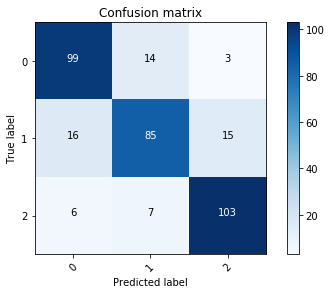

In [11]:
# compute the confusion matrix
confusion_mtx = confusion_matrix(np.array(y_true), np.array(y_pred)) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(3)) 